In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os

In [94]:
os.getcwd()

'/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/Paninski/3D-Animal-Pose'

Load ground-truth labels, which you'll have to preprocess using the designated `get_data()` module, including offsetting (not sure). 
represent a given frame as a matrix `(num_views * 2, num_bodyparts* num_frames)` while we wish to represent it as `(3, num_bodyparts)` as a 3D world. 

In [96]:
import numpy as np
import h5py
hf = h5py.File('../Video_Datasets/Sawtell-data/tank_dataset_11.h5', 
               'r')

In [98]:
print(hf.keys())

<KeysViewHDF5 ['annotated', 'annotations', 'frame_number', 'images', 'skeleton', 'skeleton_names', 'video_name']>


In [102]:
images = hf['images']
images

<HDF5 dataset "images": shape (263, 384, 512, 1), type "|u1">

In [133]:
labels = hf["annotations"] # can add np.array
labels.shape

(263, 108, 2)

In [132]:
# decode binary to ASCII
skeleton_name_list = [i.decode('UTF-8') for i in list(hf["skeleton_names"])]
#skeleton_name_list

In [ ]:
desired_bps = ['head', 'chin_base','chin_1_4','chin_mid', \ 
               'chin_3_4','chin_end', 'mid','tail', 'caudal_d', 'caudal_v']

In [ ]:
bp_to_keep = ["chin", "chin1", "chin3", "mid", "head", "caudal", "tail"]
view_names = ["top", "main", "right"]

In [485]:
# pts_array = np.concatenate((labels[:,:,0], labels[:,:,1]), axis=0)

In [486]:
pts_array = np.empty((labels.shape[0], int(labels.shape[1] / len(view_names)), 2))
x_points = []
y_points = []
skeleton_names = []
for i, name in enumerate(skeleton_name_list):
    # return a length-108 list whose entries are 1D np.arrays
    x_points.append(labels[:, i, 0])
    y_points.append(labels[:, i, 1])
    skeleton_names.append(name[:-2])
    
x_points = np.asarray(x_points).transpose()[:, :, np.newaxis]
y_points = np.asarray(y_points).transpose()[:, :, np.newaxis]
pts_array = np.concatenate((x_points, y_points), axis=-1)

In [487]:
print(skeleton_name_list)

['head_main', 'chin_base_main', 'chin1_4_main', 'chin_half_main', 'chin3_4_main', 'chin_tip_main', 'mid_main', 'fork_main', 'stripeA_main', 'stripeP_main', 'tail_neck_main', 'dorsal_main', 'anal_main', 'caudal_d_main', 'caudal_v_main', 'pectoral_L_main', 'pectoral_R_main', 'pelvic_L_main', 'pelvic_R_main', 'head_top', 'chin_base_top', 'chin1_4_top', 'chin_half_top', 'chin3_4_top', 'chin_tip_top', 'mid_top', 'fork_top', 'stripeA_top', 'stripeP_top', 'tail_neck_top', 'dorsal_top', 'anal_top', 'caudal_d_top', 'caudal_v_top', 'pectoral_L_top', 'pectoral_R_top', 'pelvic_L_top', 'pelvic_R_top', 'head_right', 'chin_base_right', 'chin1_4_right', 'chin_half_right', 'chin3_4_right', 'chin_tip_right', 'mid_right', 'fork_right', 'stripeA_right', 'stripeP_right', 'tail_neck_right', 'dorsal_right', 'anal_right', 'caudal_d_right', 'caudal_v_right', 'pectoral_L_right', 'pectoral_R_right', 'pelvic_L_right', 'pelvic_R_right', 'stage_left_floor_main', 'stage_right_floor_main', 'worm_1_top', 'worm_2_top',

from here on it works

In [488]:
skeleton_names = skeleton_name_list
# Split points into separate views
multiview_idx_to_name = {}
multiview_name_to_idx = {}

for view_name in view_names:
    multiview_name_to_idx[view_name] = []
    new_skeleton_names = []
for idx, name in enumerate(skeleton_names):  # was prev f["skeleton_names"] building on the labels data.
    if len(bp_to_keep) > 0:
        skip_bp = True
        for bp in bp_to_keep:
            if (
                bp == name.split("_")[0]
            ):  # bp == name.decode("UTF-8").split("_")[0]:
                skip_bp = False
        if skip_bp:
            continue

    new_skeleton_names.append(name)
    for view_name in view_names:
        if view_name in name.split("_")[-1]:  # name.decode("UTF-8").split("_")[-1]:
            multiview_idx_to_name[idx] = view_name
            multiview_name_to_idx[view_name].append(idx)

In [489]:
print(multiview_name_to_idx)
print(multiview_idx_to_name)

{'top': [19, 20, 21, 22, 23, 24, 25, 29, 32, 33], 'main': [0, 1, 2, 3, 4, 5, 6, 10, 13, 14], 'right': [38, 39, 40, 41, 42, 43, 44, 48, 51, 52]}
{0: 'main', 1: 'main', 2: 'main', 3: 'main', 4: 'main', 5: 'main', 6: 'main', 10: 'main', 13: 'main', 14: 'main', 19: 'top', 20: 'top', 21: 'top', 22: 'top', 23: 'top', 24: 'top', 25: 'top', 29: 'top', 32: 'top', 33: 'top', 38: 'right', 39: 'right', 40: 'right', 41: 'right', 42: 'right', 43: 'right', 44: 'right', 48: 'right', 51: 'right', 52: 'right'}


In [490]:
num_analyzed_body_parts = int(len(new_skeleton_names) / len(view_names))
num_analyzed_body_parts

10

In [491]:
if len(bp_to_keep) > 0:
    num_analyzed_body_parts = int(len(new_skeleton_names) / len(view_names))

pts_array = labels
offset = False
# (num views, num frames, num points per frame, 2)
pts_array_2d_joints = np.empty(
    shape=(len(view_names), pts_array.shape[0], num_analyzed_body_parts, 2)
)


for i, view_name in enumerate(view_names):
    # Select rows from indices
    view_indices = multiview_name_to_idx[view_name]
    view_points = pts_array[:, view_indices, :]
    if offset:
        # ToDo: make sure we can access img_settings
        view_points[:, :, 0] -= img_settings["width_lims"][i][0]
        view_points[:, :, 1] -= img_settings["height_lims"][i][0]
    pts_array_2d_joints[i, :, :, :] = view_points

In [492]:
# we were doing this previously (keeping it for now)
pts_2d = pts_array_2d_joints.reshape(
        pts_array_2d_joints.shape[0],
        pts_array_2d_joints.shape[1] * pts_array_2d_joints.shape[2],
        pts_array_2d_joints.shape[3],
    )
print(pts_2d.shape) 

(3, 2630, 2)


In [493]:
def clean_nans(pts_array_2d=None, drop_any_nan_row=False):
    # pts_array_2d should be (num_cams, num_frames * num_bodyparts, 2)
    # Clean up nans
    count_nans = np.sum(np.isnan(pts_array_2d), axis=0)[:, 0]
    if drop_any_nan_row:
        nan_rows = count_nans>0
    else:
        nan_rows = count_nans > pts_array_2d.shape[0] - 2
    pts_all_flat = np.arange(pts_array_2d.shape[1])
    pts_2d_filtered = pts_array_2d[:, ~nan_rows, :]
    clean_point_indices = pts_all_flat[~nan_rows]
    return pts_2d_filtered, clean_point_indices

In [494]:
#from utils.utils_BA import clean_nans
# ToDo: not sure that my cleanup makes sense (we remove bp on certain frames, but these are like independet observations so maybe ok)
pts_2d_filtered, clean_point_indices = clean_nans(pts_2d, True) 
#pts_2d_filtered

In [495]:
arr_for_pca = np.concatenate((pts_2d_filtered[:,:,0], 
                            pts_2d_filtered[:,:,1]),  
                             axis=0) # squeeze (x,y) coords with views
arr_for_pca.shape

(6, 1751)

In [496]:
# Dan: this was a good way to make sure reshaping is proper, consider introducing back
# arr_for_pca = np.concatenate((pts_array_2d_joints[:,:,:,0], 
#                             pts_array_2d_joints[:,:,:,1]),  
#                              axis=0) # squeeze (x,y) coords with views
# #arr_for_pca.shape
# arr_for_pca = arr_for_pca.reshape(6,-1) # squeeze num_bps*num_frames
# #arr_for_pca.shape # (num_views*2, num_bps*num_frames)

In [289]:
from sklearn.decomposition import PCA

In [497]:
pca = PCA(n_components=4, svd_solver='full')
pca.fit(arr_for_pca.T)

PCA(n_components=4, svd_solver='full')

In [498]:
print(np.sum(pca.explained_variance_ratio_))

0.9487547768900934


In [499]:
reduced_data = pca.transform(arr_for_pca.T)
reduced_data.shape

(1751, 4)

In [500]:
pca_preds = pca.inverse_transform(reduced_data)
pca_preds.shape # same shape as arr_for_pca.T

(1751, 6)

now we have to work our way back to the data

In [501]:
def undo_nan_cleanup(original_arr, clean_point_indices, cleaned_arr):
    # ToDo: add a condition that acounts for partial nan removal
    all_point_indices = np.arange(original_arr.shape[1])
    
    nan_point_indices = np.asarray(
        [x for x in all_point_indices if x not in clean_point_indices]
    )
    filled_points_2d = np.empty(original_arr.shape)
    filled_points_2d[:, clean_point_indices, :] = cleaned_arr
    filled_points_2d[:, nan_point_indices, :] = np.nan
    return filled_points_2d
# nan_undone = undo_nan_cleanup(pts_2d, 
#                               clean_point_indices, 
#                               pts_2d_filtered)

In [502]:
# now let's get back from PCA representation to a pts_2d_filtered rep
# i.e., undo this:
# arr_for_pca = np.concatenate((pts_2d_filtered[:,:,0], 
#                             pts_2d_filtered[:,:,1]),  
#                              axis=0)
pca_preds = pca_preds.T
pca_preds.shape
#recon_filtered_pts_2d = pca_preds

(6, 1751)

In [503]:
expanded_preds = np.expand_dims(pca_preds,-1)
expanded_preds.shape

(6, 1751, 1)

In [504]:
expanded_preds = np.expand_dims(pca_preds,-1)
recon_filtered_pts_2d = np.concatenate(
    (expanded_preds[:len(view_names), :,:],
    expanded_preds[len(view_names):, :,:]), axis=-1)
recon_filtered_pts_2d.shape # ToDo: check that the undoing of arr_for_pca is fine itself

(3, 1751, 2)

In [505]:
preds_reverted = undo_nan_cleanup(pts_2d, 
                              clean_point_indices, 
                              recon_filtered_pts_2d)

In [506]:
preds_reverted.shape == pts_2d.shape

True

In [507]:
preds_reverted.shape[0]

3

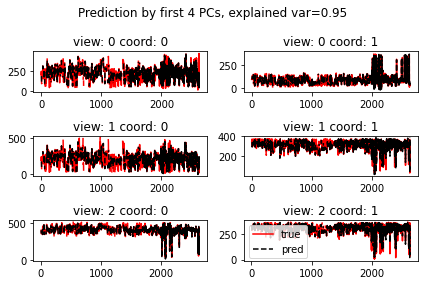

In [508]:
num_PCs = 4
fig, ax = plt.subplots(3,2)
for i in range(preds_reverted.shape[0]):
    for j in range(preds_reverted.shape[-1]):
        ax[i,j].plot(pts_2d[i,:,j].T, 'r')
        ax[i,j].plot(preds_reverted[i,:,j].T, 'k--')
        ax[i,j].set_title('view: %i coord: %i' % (i,j))
ax[i,j].legend(['true', 'pred'])
fig.suptitle('Prediction by first %i PCs, explained var=%.2f' % (num_PCs, np.sum(pca.explained_variance_ratio_)))
fig.tight_layout()

plt.savefig('preds_by_4_pc_fish.png')


    
# plt.plot(preds_reverted[:,:,0].T)
# plt.plot(pts_2d[:,:,0].T)

In [509]:
pts_2d_reshaped = pts_2d.reshape(pts_array_2d_joints.shape)
preds_reshaped = preds_reverted.reshape(pts_array_2d_joints.shape)

In [510]:
preds_reshaped.shape

(3, 263, 10, 2)

In [511]:
points_dir = Path("./PCA_reproj").resolve()
points_dir.mkdir(parents=True, exist_ok=True)

In [512]:
points_dir / ('im_%i.png' %i)

PosixPath('/Users/danbiderman/Dropbox/Columbia/1.Dan/Research/Paninski/3D-Animal-Pose/PCA_reproj/im_2.png')

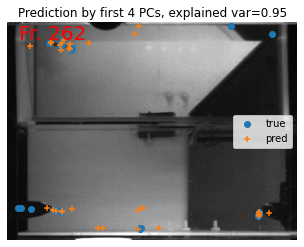

In [483]:
#images.shape
for i in range(preds_reshaped.shape[1]):
    plt.cla()
    plt.axis('off')
    plt.imshow(images[i,:,:,0], "gray")
    plt.scatter(pts_2d_reshaped[:,i,:,0].flatten(), pts_2d_reshaped[:,i,:,1].flatten())
    plt.scatter(preds_reshaped[:,i,:,0].flatten(), pts_2d_reshaped[:,i,:,1].flatten(), marker = '+')
    plt.legend(["true", "pred"])
    plt.title('Prediction by first %i PCs, explained var=%.2f' % (num_PCs, np.sum(pca.explained_variance_ratio_)))
    plt.text(x=20, y=30, s = 'Fr. %i' %i, color = 'red', fontsize = 20)
    plt.savefig(points_dir / ('im_%04d.png' %i))
    plt.xlabels = []

In [484]:
# make video from these images
image_folder = points_dir
import cv2
import os
im_list = os.listdir(image_folder)
im_list.sort()
im_list = im_list[1:]
 
img_array = []
for filename in im_list:
    img = cv2.imread(os.path.join(image_folder, filename))
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

out = cv2.VideoWriter('video_PC_4.mov',
                      cv2.VideoWriter_fourcc(*'DIVX'), 
                      2, size) # 
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [449]:
size

(432, 288)

In [183]:
# # using filter() + lambda  
# # to get string with substring
# res = []
# for subs in bp_to_keep:
#     res.append(list(filter(lambda x: subs in x, skeleton_name_list)))
#     # below returns the names
#     #res.append(list(filter(lambda x: subs in x, skeleton_name_list)))

In [ ]:
# strings = skeleton_name_list
# substring = 'tail'
# for substring in bp_to_keep:
#     strings_with_substring.append([string for string in strings if substring in string])

In [514]:
# offset = False
# # (num views, num frames, num points per frame, 2)
# pts_array_2d_joints = np.empty(
#     shape=(len(view_names), pts_array.shape[0], num_analyzed_body_parts, 2)
# )

# confidences_bp = np.empty(
#     shape=(len(view_names), pts_array.shape[0], num_analyzed_body_parts)
# )

# for i, view_name in enumerate(view_names):
#     # Select rows from indices
#     view_indices = multiview_name_to_idx[view_name]
#     view_points = pts_array[:, view_indices, :]
#     if offset:
#         view_points[:, :, 0] -= img_settings["width_lims"][i][0]
#         view_points[:, :, 1] -= img_settings["height_lims"][i][0]
#     pts_array_2d_joints[i, :, :, :] = view_points

In [513]:
# # now want to pick certain body parts
# # first create an array for one body part from three views
# separated_list = [j.split('_') for j in skeleton_name_list]
# separated_list